<a href="https://colab.research.google.com/github/Deca97/Fruits_Classification/blob/main/Fruits_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificazione di frutti esotici

# Import delle librerie necessarie

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# Caricamento dataset

In [ ]:
# Scarica il dataset direttamente dal link
url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/fruits.csv"
df = pd.read_csv(url)

df.describe()






,Peso (g),Diametro medio (mm),Lunghezza media (mm),Durezza buccia (1-10),Dolcezza (1-10)
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,47.313440,86.573100,5.298620,7.437640,3.593220
std,26.768797,64.293403,2.641993,1.812548,1.264899
min,8.570000,7.530000,1.150000,3.070000,1.250000
25%,24.797500,50.510000,2.672500,6.152500,2.570000
50%,42.380000,70.450000,5.670000,7.340000,3.535000
75%,68.080000,88.852500,7.455000,8.615000,4.465000
max,111.210000,299.890000,11.140000,13.720000,6.950000


In [ ]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Frutto                 500 non-null    object 
 1   Peso (g)               500 non-null    float64
 2   Diametro medio (mm)    500 non-null    float64
 3   Lunghezza media (mm)   500 non-null    float64
 4   Durezza buccia (1-10)  500 non-null    float64
 5   Dolcezza (1-10)        500 non-null    float64
dtypes: float64(5), object(1)
memory usage: 23.6+ KB


,Frutto,Peso (g),Diametro medio (mm),Lunghezza media (mm),Durezza buccia (1-10),Dolcezza (1-10)
0,Mela,86.40,89.68,8.69,9.61,2.41
1,Mela,77.58,73.45,6.49,7.20,3.87
2,Mela,81.95,81.66,6.40,9.09,2.88
3,Mela,66.33,36.71,6.78,8.21,2.55
4,Mela,56.73,75.69,5.78,9.15,3.88


# Analisi esplorativa

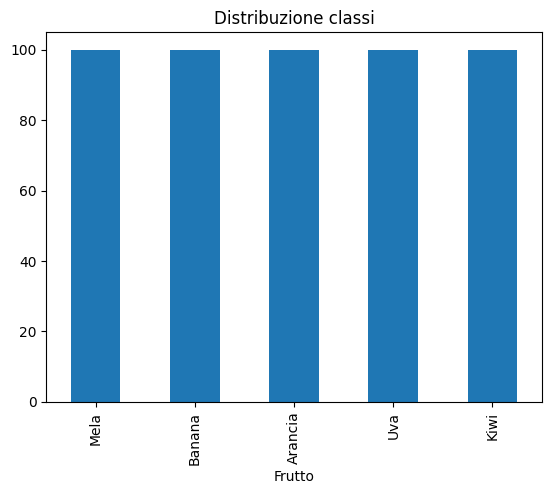

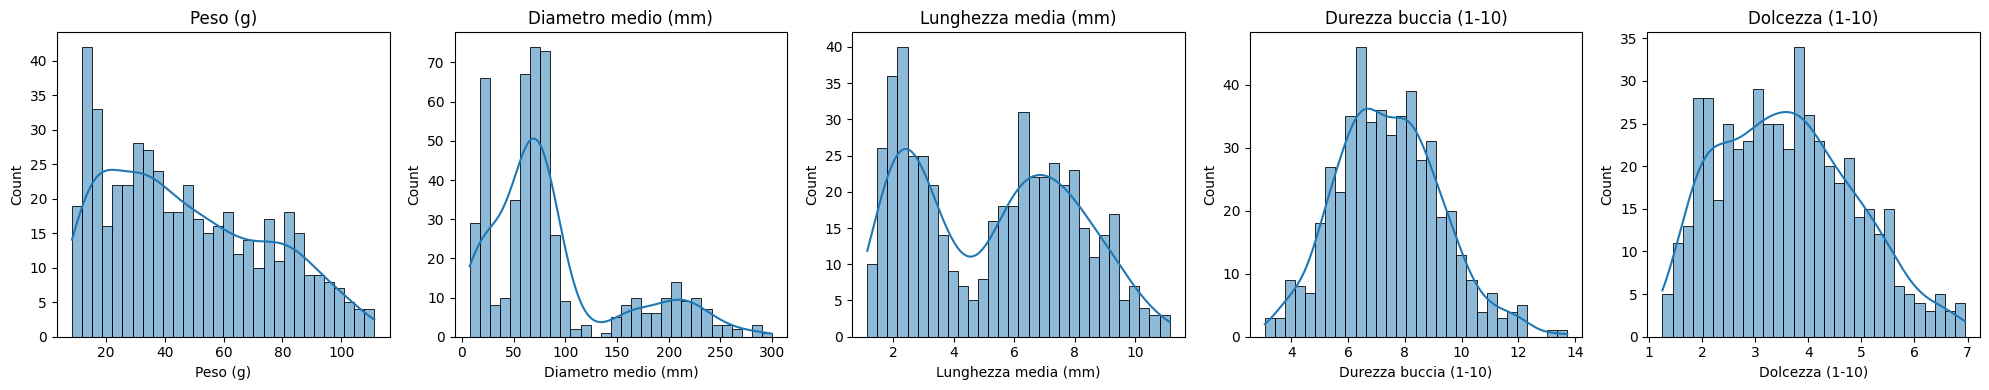

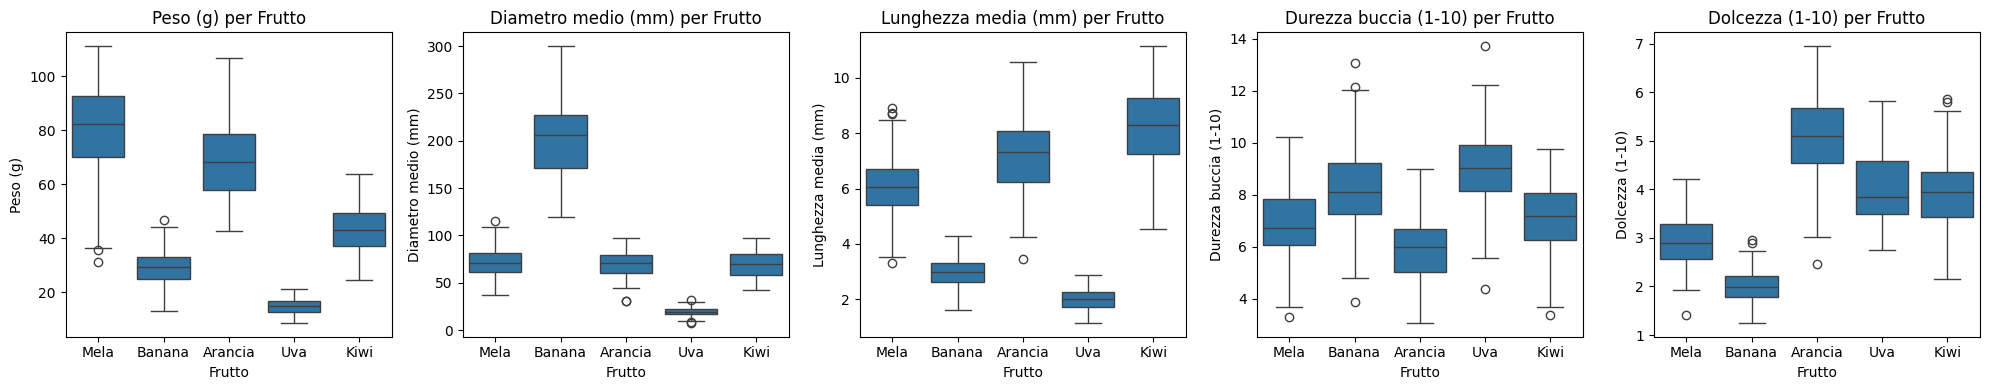

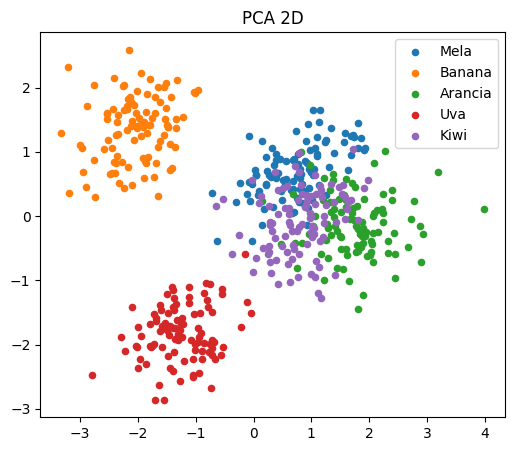

In [ ]:
# Distribuzione delle classi
df["Frutto"].value_counts().plot(kind="bar", title="Distribuzione classi")
plt.show()

# Istogrammi features numeriche
features = df.drop('Frutto', axis=1).columns

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, col in enumerate(features):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

# Boxplot features per classe
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(features):
    sns.boxplot(x="Frutto", y=col, data=df, ax=axes[i])
    axes[i].set_title(f"{col} per Frutto")
plt.tight_layout()
plt.show()

  # PCA 2D

num_cols = [c for c in df.columns if c != "Frutto"]
X_scaled = StandardScaler().fit_transform(df[num_cols])

X_pca = PCA(n_components=2).fit_transform(X_scaled)
plt.figure(figsize=(6,5))
for fr in df["Frutto"].unique():
    mask = df["Frutto"]==fr
    plt.scatter(X_pca[mask,0], X_pca[mask,1], label=fr, s=20)
plt.legend()
plt.title("PCA 2D")
plt.show()

* Le classi risultano bilanciate.
* Le variabili durezza e dolcezza mostrano distribuzione normale, mentre peso, diametro e lunghezza no.
* Le classi arancia, mela e kiwi mostrano caratteristiche simili soprattutto per quanto riguarda il peso e le dimensioni, mentre Banana e Uva appaiono significativamente diverse.

# Preprocessing

In [ ]:
X = df[num_cols]
y = df["Frutto"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols)
])


# Model development

In [ ]:
pipe = Pipeline([
    ("preprocess", preprocess),
    ("clf", KNeighborsClassifier())
])

param_grid = {
    "clf__n_neighbors": [5],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1,2],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(pipe, param_grid, scoring="accuracy", cv=cv, n_jobs=-1, refit=True)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("CV best accuracy:", grid.best_score_)


Best params: {'clf__n_neighbors': 5, 'clf__p': 2, 'clf__weights': 'distance'}
CV best accuracy: 0.9349999999999999


Il modello KNN selezionato mostra ottime prestazioni: la cross-validation dà un’accuratezza media di circa 93,5%

# Model evaluation

Test accuracy: 0.92

Classification Report:
               precision    recall  f1-score   support

     Arancia       0.78      0.90      0.84        20
      Banana       1.00      1.00      1.00        20
        Kiwi       0.89      0.85      0.87        20
        Mela       0.94      0.85      0.89        20
         Uva       1.00      1.00      1.00        20

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100



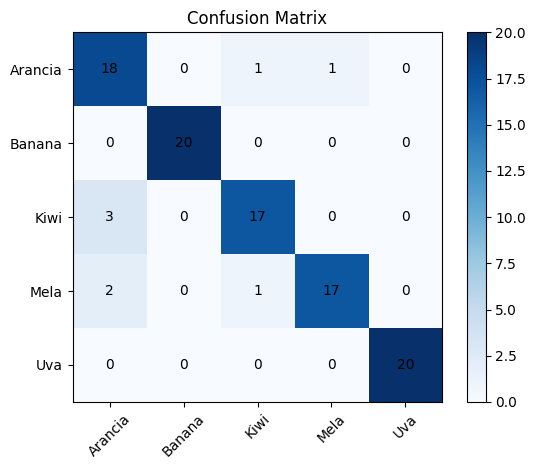

In [ ]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.imshow(cm, cmap="Blues")
plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)
plt.title("Confusion Matrix")
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i,cm[i,j],ha="center",va="center")
plt.show()


Dal classification report si nota:

* Tutte le classi hanno valori elevati di precision e recall, con Banana e Uva perfette (1.0).

* L’Arancia, Kiwi e Mela hanno valori leggermente inferiori, indicando qualche errore di classificazione tra queste tre classi, dovuto a caratteristiche simili.

In generale, il modello è robusto e bilanciato, con errori minimi su classi simili, e risulta adatto per la classificazione dei frutti esotici.